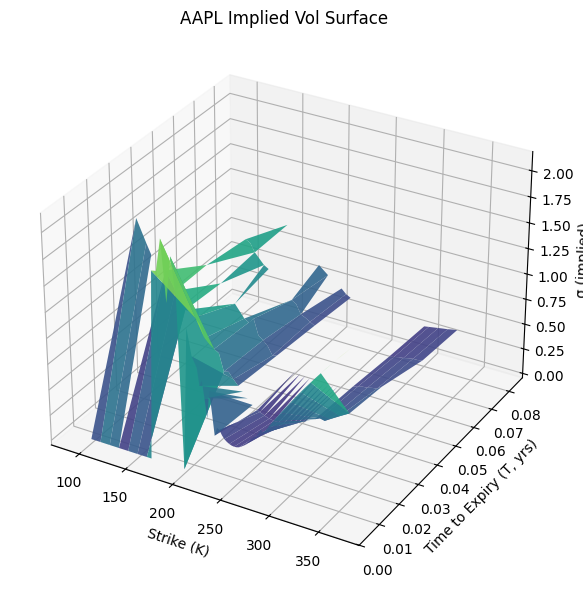

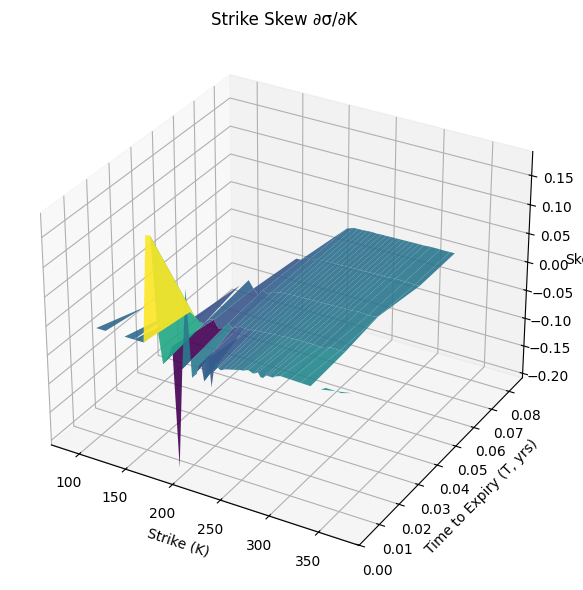

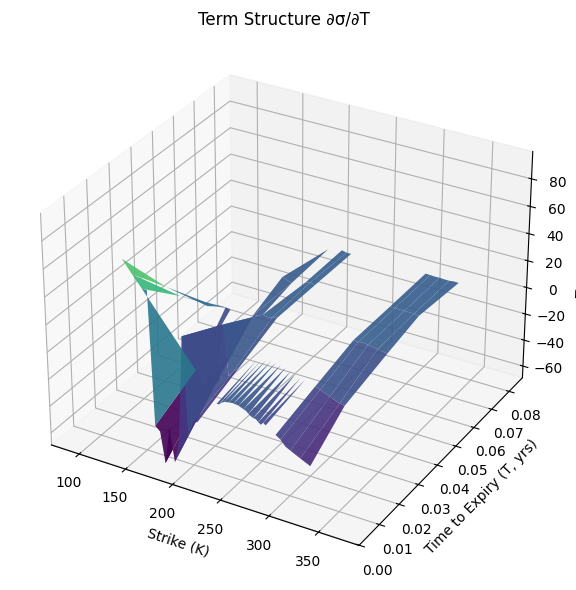

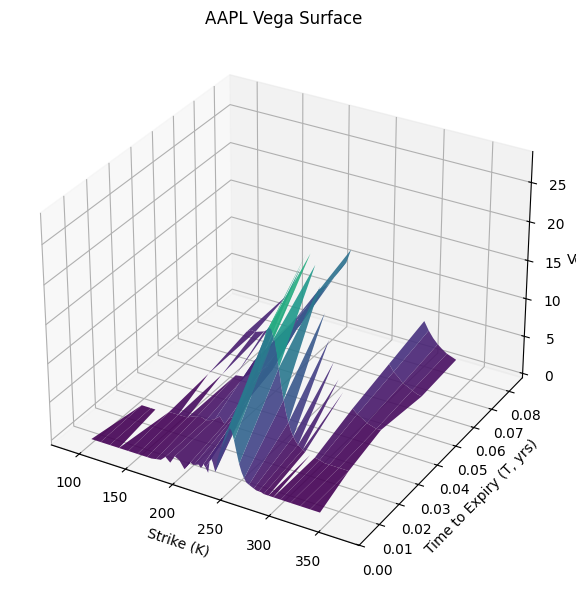

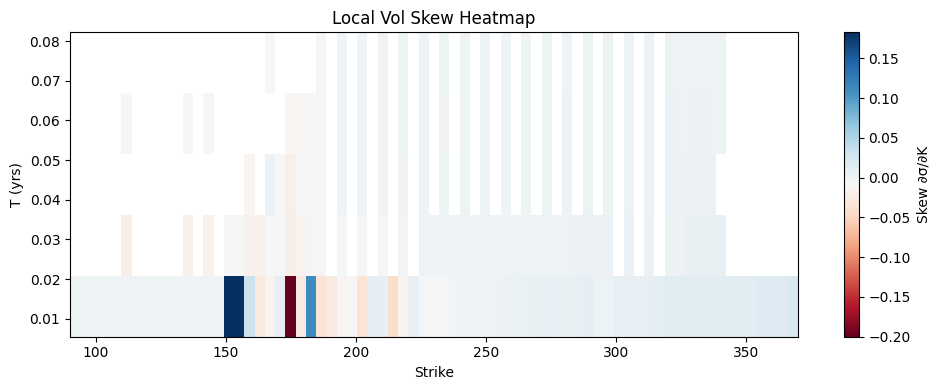

In [1]:
# Step 11 — Surface Greeks and Sensitivity Maps
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa
from scipy.stats import norm
import yfinance as yf
from datetime import datetime, timezone

# ---------- 1. Black–Scholes Helpers ----------
def bs_vega(S,K,T,r,sigma):  # Vega per 1 vol-point (e.g. 1.0 = 100%)
    if T<=0 or sigma<=0: return 0.0
    d1=(np.log(S/K)+(r+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    return S*norm.pdf(d1)*np.sqrt(T)

def build_iv_surface(ticker="AAPL", max_expiries=5, r=0.02):
    tk=yf.Ticker(ticker)
    S=float(tk.history(period="1d")["Close"].iloc[-1])
    now=datetime.now(timezone.utc)
    rows=[]
    for exp in tk.options[:max_expiries]:
        opt=tk.option_chain(exp).calls
        if opt.empty: continue
        opt["mid"]=(opt["bid"].fillna(0)+opt["ask"].fillna(0))/2
        opt=opt.dropna(subset=["mid"])
        T=max((pd.to_datetime(exp).tz_localize("UTC")-now).days/365.0,1e-6)
        opt["iv"]=opt.apply(lambda r_: np.nan if r_["mid"]<=0 else
                            implied_vol_binary(r_["mid"],S,float(r_["strike"]),T,r=r),axis=1)
        opt["T"]=T
        rows.append(opt[["strike","iv","T"]])
    df=pd.concat(rows,ignore_index=True).dropna(subset=["iv"])
    return S, df

def implied_vol_binary(C_mkt,S,K,T,r=0.02,tol=1e-6,lo=1e-6,hi=5.0):
    from math import log,sqrt,exp
    if T<=0: return 0.0
    for _ in range(80):
        mid=0.5*(lo+hi)
        d1=(log(S/K)+(r+0.5*mid**2)*T)/(mid*sqrt(T))
        d2=d1-mid*sqrt(T)
        price=S*norm.cdf(d1)-K*exp(-r*T)*norm.cdf(d2)
        if abs(price-C_mkt)<tol: return mid
        if price>C_mkt: hi=mid
        else: lo=mid
    return mid

# ---------- 2. Compute Surface + Derivatives ----------
ticker="AAPL"
S, iv_table = build_iv_surface(ticker)
pivot=iv_table.pivot_table(index="T",columns="strike",values="iv")
Tvals, Kvals = pivot.index.values, pivot.columns.values
sigma=pivot.values

# Partial derivatives
dSigma_dK=np.gradient(sigma,axis=1)/(Kvals[1]-Kvals[0])
dSigma_dT=np.gradient(sigma,axis=0)/(Tvals[1]-Tvals[0])

# Compute Vega grid (same shape)
Vega=np.zeros_like(sigma)
for i,T in enumerate(Tvals):
    for j,K in enumerate(Kvals):
        Vega[i,j]=bs_vega(S,K,T,0.02,sigma[i,j])

# ---------- 3. 3D Visualization ----------
def plot_surface(X,Y,Z,title,zlabel):
    fig=plt.figure(figsize=(10,6))
    ax=fig.add_subplot(111,projection="3d")
    ax.plot_surface(X,Y,Z,cmap="viridis",alpha=0.9)
    ax.set_xlabel("Strike (K)"); ax.set_ylabel("Time to Expiry (T, yrs)")
    ax.set_zlabel(zlabel); ax.set_title(title)
    plt.tight_layout(); plt.show()

Kmesh,Tmesh=np.meshgrid(Kvals,Tvals)
plot_surface(Kmesh,Tmesh,sigma,f"{ticker} Implied Vol Surface","σ (implied)")
plot_surface(Kmesh,Tmesh,dSigma_dK,"Strike Skew ∂σ/∂K","Skew")
plot_surface(Kmesh,Tmesh,dSigma_dT,"Term Structure ∂σ/∂T","Term Slope")
plot_surface(Kmesh,Tmesh,Vega,f"{ticker} Vega Surface","Vega")

# ---------- 4. Heatmap Summary ----------
plt.figure(figsize=(10,4))
plt.imshow(dSigma_dK,aspect="auto",origin="lower",
           extent=[Kvals.min(),Kvals.max(),Tvals.min(),Tvals.max()],
           cmap="RdBu"); plt.colorbar(label="Skew ∂σ/∂K")
plt.xlabel("Strike"); plt.ylabel("T (yrs)")
plt.title("Local Vol Skew Heatmap")
plt.tight_layout(); plt.show()
